In [1]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [2]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/imagen/participants.csv"
embeddings_subpath = "imagen_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/IHI_imagen_without_residualization.csv"
label = "C5_L"
max_iter = 2000
cv = 3

In [3]:
participants = pd.read_csv(participants_file, index_col=0)


In [4]:
participants.head()

,Comments,C0_L,C1_L,C2_L,C3_L,C4_L,C5_L,SCi_L,C0_R,C1_R,...,LAcc,RAcc,Age for timestamp,Age for processed_timestamp,ni_mass,ni_height,Gender,Handedness,ImagingCentreID,ImagingCentreCity
Subject,,,,,,,,,,,,,,,,,,,,,
1274,NaN,N,0.5,1.0,1.0,0,0.0,2.5,N,0.5,...,381.616219,331.611335,5487.0,5487.0,50.0,154.0,Female,Right,2,NOTTINGHAM
22453,NaN,N,1.0,0.0,0.5,0,0.0,1.5,N,1.0,...,438.200693,407.934579,NaN,NaN,76.0,172.0,Male,Right,8,DRESDEN
75717,NaN,N,0.0,1.0,0.5,0,0.0,1.5,Y,1.5,...,615.905872,410.603915,5395.0,5395.0,61.0,171.0,Male,Right,2,NOTTINGHAM
106601,NaN,N,0.0,0.5,1.0,0,0.0,1.5,N,0.0,...,557.949231,546.105969,5098.0,5098.0,50.0,162.0,Male,Left,7,PARIS
106871,NaN,N,0.0,0.5,0.0,0,0.0,0.5,N,0.5,...,552.685679,450.044053,5720.0,5720.0,47.0,161.0,Female,Right,8,DRESDEN


In [5]:
participants = participants[["C0_L", "C1_L", "C2_L", "C3_L", "C4_L", "C5_L"]]

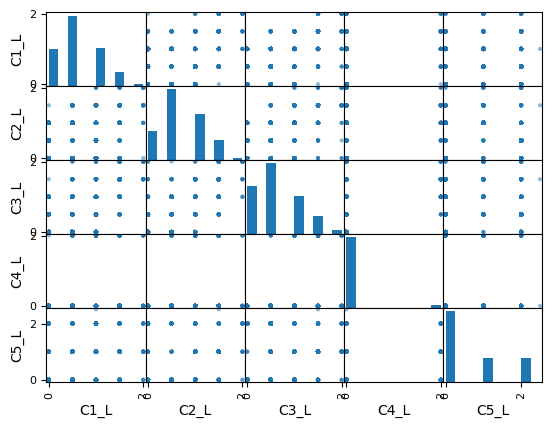

In [6]:
a = pd.plotting.scatter_matrix(participants)

In [7]:
participants = participants[[label]].dropna()
participants[label].unique()

array([0. , 2. , 1. , 2.5])

In [8]:
participants.dtypes

C5_L    float64
dtype: object

In [9]:
participants

,C5_L
Subject,
1274,0.0
22453,0.0
75717,0.0
106601,0.0
106871,0.0
...,...
99873252,2.0
99875982,0.0
99888850,0.0


array([[<Axes: title={'center': 'C5_L'}>]], dtype=object)

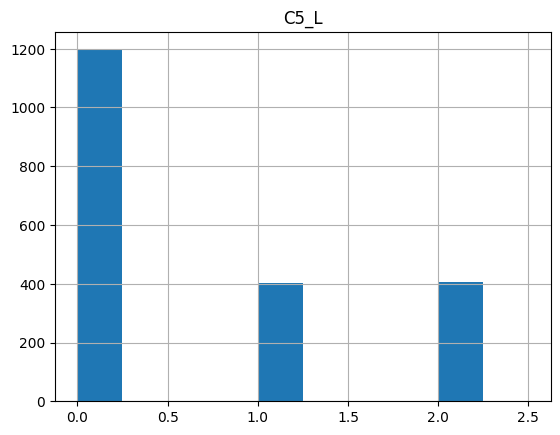

In [10]:
participants.hist()

In [11]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [12]:
model_paths = get_model_paths(path_champollion)

In [13]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [14]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    df2 = X.copy()

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path)

In [15]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
0.9494662820259756
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
0.9929072346444036
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
1.0069164509500048
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
1.4597183707163337
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
2.2133052694743833
Treating S.T.s.-S.GSM._left: STs-SGSM_left/13-57-40_59 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STs-SGSM_left/13-5

In [16]:
df = pd.DataFrame(result, columns=['region', 'f_value', 'p_value', 'model_name', 'region_path', 'model_path'])

In [17]:
df

,region,f_value,p_value,model_name,region_path,model_path
0,S.C.-sylv._left,0.949466,6.987076e-01,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,0.992907,5.205858e-01,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,1.006916,4.616206e-01,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,1.459718,1.284117e-05,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,2.213305,1.029339e-20,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
93,S.C.-S.Po.C._left,1.054532,2.782646e-01,16-46-17_3,SC-SPoC_left/16-46-17_3,/neurospin/dico/data/deep_folding/current/mode...
94,S.C.-S.Po.C._left,1.065742,2.415555e-01,16-46-17_0,SC-SPoC_left/16-46-17_0,/neurospin/dico/data/deep_folding/current/mode...
95,S.C.-S.Po.C._left,1.119097,1.096087e-01,14-55-36_0,SC-SPoC_left/14-55-36_0,/neurospin/dico/data/deep_folding/current/mode...
96,S.C.-S.Po.C._left,1.071820,2.229212e-01,16-46-17_1,SC-SPoC_left/16-46-17_1,/neurospin/dico/data/deep_folding/current/mode...


In [18]:
df = df.groupby("region").first().reset_index()
df.head()

,region,f_value,p_value,model_name,region_path,model_path
0,CINGULATE_left,0.840722,0.961625,17-13-32_0,2024-07-15/17-13-32_0,/neurospin/dico/data/deep_folding/current/mode...
1,CINGULATE_right,0.890782,0.881127,09-52-22_75,CINGULATE_right/09-52-22_75,/neurospin/dico/data/deep_folding/current/mode...
2,F.C.L.p.-S.GSM._left,1.011659,0.441922,10-57-28_18,FCLp-SGSM_left/10-57-28_18,/neurospin/dico/data/deep_folding/current/mode...
3,F.C.L.p.-S.GSM._right,1.115133,0.117004,11-40-20_0,FCLp-SGSM_right/11-40-20_0,/neurospin/dico/data/deep_folding/current/mode...
4,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,1.270038,0.004346,18-59-14_0,FCLp-subsc-FCLa-INSULA_left/18-59-14_0,/neurospin/dico/data/deep_folding/current/mode...


In [19]:
df['side'] = df['region'].str.split('_').str[-1]

In [20]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f2_value, ascending=False)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=-np.log10(0.05/60), color='black', linestyle='-')
    ax.axvline(x=-np.log10(0.01/60), color='red', linestyle='-')
    ax.barh(res[region_name], -np.log10(res[f2_value]), fill=True, color='lightgray')
    # ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)
    ax.set_xlabel("-log10(p)")


In [21]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,model_name,region_path,model_path,side
8,F.Coll.-S.Rh._left,4.682804,1.691280e-84,09-45-57_0,FColl-SRh_left/09-45-57_0,/neurospin/dico/data/deep_folding/current/mode...,left
44,S.T.i.-S.O.T.lat._left,2.993745,3.980377e-40,09-36-46_0,STi-SOTlat_left/09-36-46_0,/neurospin/dico/data/deep_folding/current/mode...,left
9,F.Coll.-S.Rh._right,2.213305,1.029339e-20,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
46,S.T.i.-S.T.s.-S.T.pol._left,1.859714,6.668333e-13,14-30-34_34,STi-STs-STpol_left/14-30-34_34,/neurospin/dico/data/deep_folding/current/mode...,left
45,S.T.i.-S.O.T.lat._right,1.789573,1.763550e-11,09-36-46_1,STi-SOTlat_right/09-36-46_1,/neurospin/dico/data/deep_folding/current/mode...,right
47,S.T.i.-S.T.s.-S.T.pol._right,1.459718,1.284117e-05,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
53,S.T.s.br._right,1.360188,3.392191e-04,16-33-12_1,STsbr_right/16-33-12_1,/neurospin/dico/data/deep_folding/current/mode...,right
56,Sc.Cal.-S.Li._left,1.359829,3.429618e-04,09-28-12_0,ScCal-SLi_left/09-28-12_0,/neurospin/dico/data/deep_folding/current/mode...,left
51,S.T.s._right,1.342212,5.832332e-04,11-43-38_1,STs_right/11-43-38_1,/neurospin/dico/data/deep_folding/current/mode...,right
50,S.T.s._left,1.312978,1.359905e-03,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left


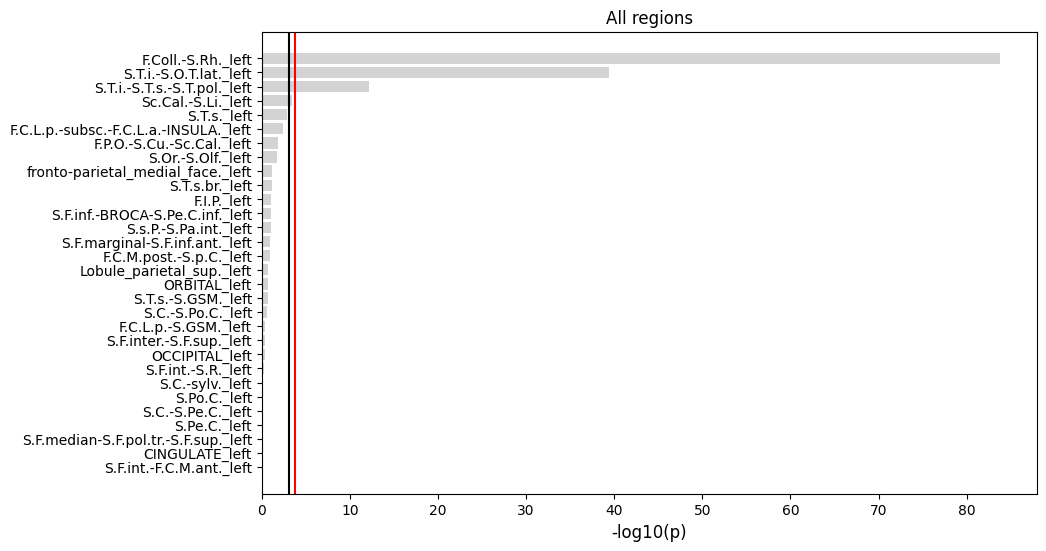

In [22]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

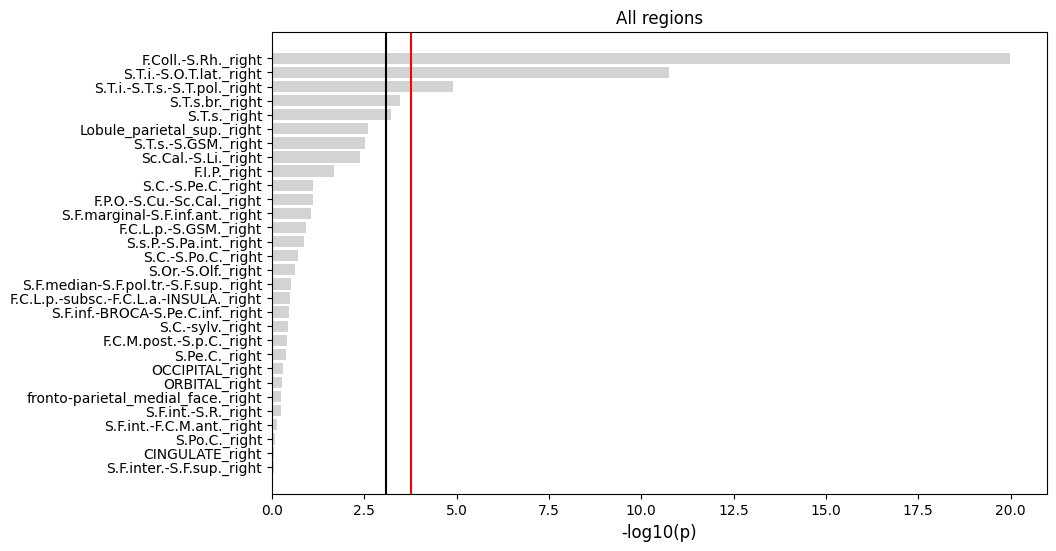

In [23]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [24]:
df

,region,f_value,p_value,model_name,region_path,model_path,side
0,CINGULATE_left,0.840722,9.616249e-01,17-13-32_0,2024-07-15/17-13-32_0,/neurospin/dico/data/deep_folding/current/mode...,left
1,CINGULATE_right,0.890782,8.811266e-01,09-52-22_75,CINGULATE_right/09-52-22_75,/neurospin/dico/data/deep_folding/current/mode...,right
2,F.C.L.p.-S.GSM._left,1.011659,4.419223e-01,10-57-28_18,FCLp-SGSM_left/10-57-28_18,/neurospin/dico/data/deep_folding/current/mode...,left
3,F.C.L.p.-S.GSM._right,1.115133,1.170040e-01,11-40-20_0,FCLp-SGSM_right/11-40-20_0,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,1.270038,4.346098e-03,18-59-14_0,FCLp-subsc-FCLa-INSULA_left/18-59-14_0,/neurospin/dico/data/deep_folding/current/mode...,left
5,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,1.043607,3.167886e-01,19-49-20_193,FCLp-subsc-FCLa-INSULA_right/19-49-20_193,/neurospin/dico/data/deep_folding/current/mode...,right
6,F.C.M.post.-S.p.C._left,1.112053,1.230039e-01,15-09-24_0,FCMpost-SpC_left/15-09-24_0,/neurospin/dico/data/deep_folding/current/mode...,left
7,F.C.M.post.-S.p.C._right,1.025676,3.851066e-01,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
8,F.Coll.-S.Rh._left,4.682804,1.691280e-84,09-45-57_0,FColl-SRh_left/09-45-57_0,/neurospin/dico/data/deep_folding/current/mode...,left
9,F.Coll.-S.Rh._right,2.213305,1.029339e-20,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right


In [25]:
# df.to_csv(output_filename)